# Lib

In [18]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

from torchvision.datasets import MNIST

In [19]:
#os.chdir("/content/drive/MyDrive/AD Last Research")

# Helper Functions

In [20]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    tsne = TSNE(n_components=2, random_state=0,  learning_rate='auto', init='random')
    x_2d = tsne.fit_transform(x)

    return x_2d

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [23]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

# Gen

In [24]:
from mymodels.generator import Generator_XL, Generator_S

In [25]:
generator = Generator_S(features=64,
                        img_size=32,
                        latent_dim=100,
                        channels=3)
count_parameters(generator)

1051139

1051139

# Disc

In [26]:
from mymodels.discriminator import Discriminator

In [27]:
discriminator = Discriminator(features=32, channels=3, img_size=32, optimization='gan')

In [28]:
count_parameters(discriminator)

390337

390337

# Data

In [36]:
from dataset import customdataset
from dataset.customdataset import get_dataset_2_classes
from torch.utils.data import ConcatDataset

In [39]:
img_size = 32
channels = 1
batch_size = 10
normal_label = 8
ano_label = 1
num_data = 1000

In [38]:
# Datasets
train_normal_ds, train_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=True,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

test_normal_ds, test_ano_ds = get_dataset_2_classes(dataset_name='mnist', train=False,
                                                      normal_label=normal_label, ano_label=ano_label,
                                                      img_size=img_size, channels=channels,
                                                      data_path="./MNIST", download=True)

In [67]:
# Dataloader for GAN
train_normal_loader = DataLoader(train_normal_ds, batch_size=batch_size,
                                 sampler=SubsetRandomSampler(list(range(num_data))))

In [70]:
# Dataloader for VIT
train_ds = ConcatDataset([train_normal_ds, train_ano_ds])
train_indx = SubsetRandomSampler(list(np.floor(np.random.uniform(0, len(train_ds), num_data)).astype(int)))
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=train_indx)

# Vanilla GAN

### Hyperparameters

In [34]:
device = 'cuda'
latent_dim = 100

### All in One

In [71]:
# Nets
generator = Generator_S(features=64,
                        img_size=img_size,
                        latent_dim=latent_dim,
                        channels=channels).to(device)

discriminator = Discriminator(features=16, channels=channels, img_size=img_size, optimization='gan', last_bias = False).to(device)

In [72]:
# Loss & Optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters())
optimizer_D = optim.Adam(discriminator.parameters())

### Re-Init

In [73]:
# WRONG

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [74]:
generator = generator.apply(weights_init_normal)
discriminator = discriminator.apply(weights_init_normal)

### Train

In [75]:
save_tsne = {}
total_G_loss = 0.0
total_D_loss = 0.0

In [76]:
device = 'cuda'

init_epoch = 615
num_epochs = 1000
sample_interval = 25

In [35]:
root_bp = "./results/vanilla_gan_research/last_parameters.pt"

info = torch.load(root_bp)
init_epoch = info['epoch']
generator.load_state_dict(info['state_dict_G'])
discriminator.load_state_dict(info['state_dict_D'])
optimizer_G.load_state_dict(info['optimizer_G'])
optimizer_D.load_state_dict(info['optimizer_D'])
save_tsne = info['save_tsne']

RuntimeError: Error(s) in loading state_dict for Generator_S:
	size mismatch for conv_layers.9.weight: copying a param with shape torch.Size([1, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([3, 64, 3, 3]).
	size mismatch for conv_layers.9.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([3]).

# Research on Discri

### Datas

In [30]:
for _, (real_images, _) in enumerate(test_loader_normal):
  images_test_normal = real_images.cpu()

In [31]:
for _, (real_images, _) in enumerate(test_loader_ano):
  images_test_ano = real_images.cpu()

In [32]:
z = torch.FloatTensor(np.random.normal(0, 1, (images_test_normal.shape[0], latent_dim))).cpu()
generator = generator.cpu()
discriminator = discriminator.cpu()
gen_imgs = generator(z)

In [33]:
gen_imgs.shape

torch.Size([974, 1, 32, 32])

### Scores

In [34]:
# Normal
print("\nNormal:")
print(discriminator(images_test_normal).mean())

print("\nFake:")
print(discriminator(gen_imgs).mean())

print("\nAno:")
print(discriminator(images_test_ano).mean())


Normal:
tensor(0.8446, grad_fn=<MeanBackward0>)

Fake:
tensor(0.2817, grad_fn=<MeanBackward0>)

Ano:
tensor(0.5461, grad_fn=<MeanBackward0>)


In [35]:
# Normal
print("\nNormal:")
print(discriminator(images_test_normal).std())

print("\nFake:")
print(discriminator(gen_imgs).std())

print("\nAno:")
print(discriminator(images_test_ano).std())


Normal:
tensor(0.0745, grad_fn=<StdBackward0>)

Fake:
tensor(0.1358, grad_fn=<StdBackward0>)

Ano:
tensor(0.1706, grad_fn=<StdBackward0>)


### TSNE FE Discriminator

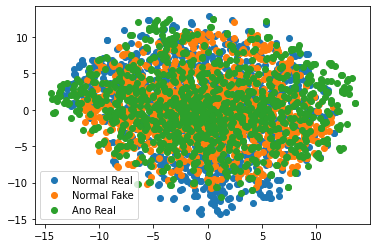

In [36]:
features_normal_real = discriminator.conv_layers(images_test_normal).flatten(1)
features_normal_fake = discriminator.conv_layers(gen_imgs).flatten(1)
features_ano_real = discriminator.conv_layers(images_test_ano).flatten(1)

features_normal_real_2D = get_2d_tsne(features_normal_real.detach().cpu())
features_normal_fake_2D = get_2d_tsne(features_normal_fake.detach().cpu())
features_ano_real_2D = get_2d_tsne(features_ano_real.detach().cpu())


plt.figure()
plt.scatter(features_normal_real_2D[:, 0], features_normal_real_2D[:, 1], label='Normal Real')
plt.scatter(features_normal_fake_2D[:, 0], features_normal_fake_2D[:, 1], label='Normal Fake')
plt.scatter(features_ano_real_2D[:, 0], features_ano_real_2D[:, 1], label='Ano Real')
plt.legend()

### TSNE W Generator

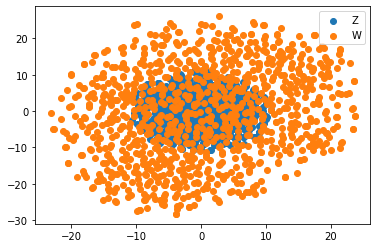

In [37]:
features_z = z
features_w = generator.linear_layer(z)

features_z_2D = get_2d_tsne(features_z.detach().cpu())
features_w_2D = get_2d_tsne(features_w.detach().cpu())


plt.figure()
plt.scatter(features_z_2D[:, 0], features_z_2D[:, 1], label='Z')
plt.scatter(features_w_2D[:, 0], features_w_2D[:, 1], label='W')
plt.legend()

### Visualiztion

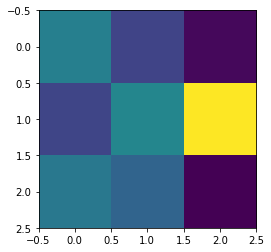

In [38]:
kernel = 2
plt.imshow(
    discriminator.conv_layers[0].weight[kernel].detach().cpu()[0]
)

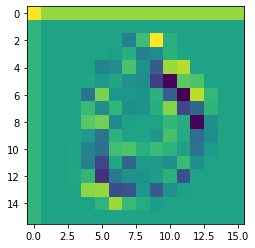

In [39]:
kernel = 10
plt.imshow(
    discriminator.conv_layers[0](images_test_ano)[0][kernel].detach().cpu()
)

### Supervised Learning

### Dataset

In [61]:
# Fake Dataset
z = torch.FloatTensor(np.random.normal(0, 1, (images_test_normal.shape[0], latent_dim))).cpu()
generator = generator.cpu()
gen_imgs = generator(z).detach().cpu()
gen_imgs = gen_imgs.squeeze(1).detach().cpu().numpy()

In [62]:
train_ds_classify = customdataset.get_train_dataset_classify(train_dataset_normal, gen_imgs, img_size, channels)
train_loader_classify = DataLoader(train_ds_classify, batch_size=64, shuffle=True)

In [63]:
test_ds_classify = customdataset.get_test_dataset_classify(test_dataset_normal, test_dataset_ano)
test_loader_classify = DataLoader(test_ds_classify, batch_size=64, shuffle=True)

### Net

In [135]:
class Classify(nn.Module):
    def __init__(self, discriminator, features, img_size):
        super(Classify, self).__init__()

        self.ds_size = img_size // 2 ** 4

        self.conv_layers = discriminator.conv_layers

        self.fc = nn.Sequential(
            #nn.BatchNorm1d(features*8 * self.ds_size ** 2),
            nn.Linear(features*8 * self.ds_size ** 2, 100),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(100, 25),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(25, 2)
        )

    def forward(self, x):
        return self.fc(
            self.conv_layers(
                x
            ).flatten(1)
        )

In [194]:
class Classify(nn.Module):
    def __init__(self, discriminator, features, img_size):
        super(Classify, self).__init__()

        self.ds_size = img_size // 2 ** 4

        self.conv_layers = discriminator.conv_layers

        self.fc = nn.Sequential(
            #nn.BatchNorm1d(features*8 * self.ds_size ** 2),
            nn.Linear(features*8 * self.ds_size ** 2, 100),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Dropout(0.2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(
            self.conv_layers(
                x
            ).flatten(1)
        )

In [195]:
# TEST
classifier = Classify(discriminator, 16, 32).cuda()
classifier(images_test_normal.cuda()).shape

torch.Size([974, 1])

In [196]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01)

In [197]:
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01)

### Training

In [199]:
n_epochs = 100
train_loss_min = np.Inf

for epoch in range(n_epochs):
    train_loss = 0
    for i, (real_images, _) in enumerate(train_loader_normal):
        torch.cuda.empty_cache()
        # Preprocessing ##############################################
        valid = torch.FloatTensor(real_images.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_images.shape[0], 1).fill_(0.0).to(device)
        real_images = real_images.to(device)
        generator = generator.to(device)
        classifier = classifier.to(device)

        classifier.train()
        # Train Generator ########################################
        optimizer.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)

        loss_fake = criterion(classifier(gen_imgs), fake)
        loss_real = criterion(classifier(real_images), valid)
        loss = 0.5*(loss_fake + loss_real)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * real_images.size(0)

    train_loss = train_loss / len(train_loader_normal.sampler)

    classifier.eval()
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if train_loss <= train_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        train_loss_min,
        train_loss))
        torch.save(classifier.state_dict(), 'model.pt')
        valid_loss_min = train_loss

Epoch: 1 	Training Loss: 0.684171 	Validation Loss: 0.684171
Validation loss decreased (inf --> 0.684171).  Saving model ...
Epoch: 2 	Training Loss: 0.684149 	Validation Loss: 0.684149
Validation loss decreased (inf --> 0.684149).  Saving model ...
Epoch: 3 	Training Loss: 0.681651 	Validation Loss: 0.681651
Validation loss decreased (inf --> 0.681651).  Saving model ...
Epoch: 4 	Training Loss: 0.686458 	Validation Loss: 0.686458
Validation loss decreased (inf --> 0.686458).  Saving model ...
Epoch: 5 	Training Loss: 0.687893 	Validation Loss: 0.687893
Validation loss decreased (inf --> 0.687893).  Saving model ...
Epoch: 6 	Training Loss: 0.684718 	Validation Loss: 0.684718
Validation loss decreased (inf --> 0.684718).  Saving model ...
Epoch: 7 	Training Loss: 0.684362 	Validation Loss: 0.684362
Validation loss decreased (inf --> 0.684362).  Saving model ...
Epoch: 8 	Training Loss: 0.683183 	Validation Loss: 0.683183
Validation loss decreased (inf --> 0.683183).  Saving model ...


KeyboardInterrupt: 

In [173]:
# number of epochs to train the model
n_epochs = 100
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0


    ###################
    # train the model #
    ###################
    classifier.train() # prep model for training
    for data,label in train_loader_classify:
        data = data.to(device)
        label = label.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = classifier(data)
        # calculate the loss
        output = output.squeeze(1)
        loss = criterion(output,label.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)


     ######################
    # validate the model #
    ######################
    """
    classifier.eval()  # prep model for evaluation
    for data,label in test_loader_classify:
        data = data.to(device)
        label = label.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = classifier(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss
        valid_loss = loss.item() * data.size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    """

    train_loss = train_loss / len(train_loader_classify.sampler)
    #valid_loss = valid_loss / len(test_loader_classify.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        train_loss
        #valid_loss
        ))

    # save model if validation loss has decreased
    if train_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        train_loss))
        torch.save(classifier.state_dict(), 'model.pt')
        valid_loss_min = train_loss

    """
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(classifier.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
    """

Epoch: 1 	Training Loss: 0.142293 	Validation Loss: 0.142293
Validation loss decreased (inf --> 0.142293).  Saving model ...
Epoch: 2 	Training Loss: 0.145064 	Validation Loss: 0.145064
Epoch: 3 	Training Loss: 0.142163 	Validation Loss: 0.142163
Validation loss decreased (0.142293 --> 0.142163).  Saving model ...
Epoch: 4 	Training Loss: 0.143769 	Validation Loss: 0.143769
Epoch: 5 	Training Loss: 0.140225 	Validation Loss: 0.140225
Validation loss decreased (0.142163 --> 0.140225).  Saving model ...
Epoch: 6 	Training Loss: 0.135977 	Validation Loss: 0.135977
Validation loss decreased (0.140225 --> 0.135977).  Saving model ...
Epoch: 7 	Training Loss: 0.143967 	Validation Loss: 0.143967
Epoch: 8 	Training Loss: 0.143669 	Validation Loss: 0.143669
Epoch: 9 	Training Loss: 0.138492 	Validation Loss: 0.138492
Epoch: 10 	Training Loss: 0.133967 	Validation Loss: 0.133967
Validation loss decreased (0.135977 --> 0.133967).  Saving model ...
Epoch: 11 	Training Loss: 0.141219 	Validation Lo

KeyboardInterrupt: 

In [200]:
classifier.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [140]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classifier.eval() # prep model for evaluation
for data, target in train_loader_classify:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = classifier(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(classifier.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

### TSNE

In [201]:
for _, (real_images, _) in enumerate(test_loader_normal):
  images_test_normal = real_images.cpu()

In [202]:
for _, (real_images, _) in enumerate(test_loader_ano):
  images_test_ano = real_images.cpu()

In [203]:
z = torch.FloatTensor(np.random.normal(0, 1, (images_test_normal.shape[0], latent_dim))).cpu()
generator = generator.cpu()
gen_imgs = generator(z)
classifier = classifier.cpu()

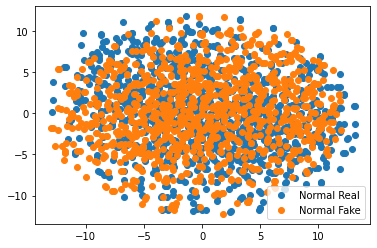

In [204]:
features_normal_real = classifier.conv_layers(images_test_normal).flatten(1)
features_normal_fake = classifier.conv_layers(gen_imgs).flatten(1)
#features_ano_real = classifier.conv_layers(images_test_ano).flatten(1)

features_normal_real_2D = get_2d_tsne(features_normal_real.detach().cpu())
features_normal_fake_2D = get_2d_tsne(features_normal_fake.detach().cpu())
#features_ano_real_2D = get_2d_tsne(features_ano_real.detach().cpu())


plt.figure()
plt.scatter(features_normal_real_2D[:, 0], features_normal_real_2D[:, 1], label='Normal Real')
plt.scatter(features_normal_fake_2D[:, 0], features_normal_fake_2D[:, 1], label='Normal Fake')
#plt.scatter(features_ano_real_2D[:, 0], features_ano_real_2D[:, 1], label='Ano Real')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


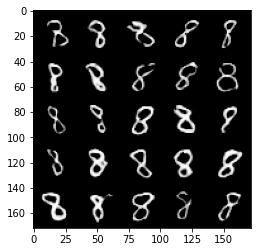

In [207]:
show_tensor_images(gen_imgs, size=(channels, img_size, img_size))

In [205]:
# Normal
print("\nNormal:")
print(discriminator(images_test_normal).mean())

print("\nFake:")
print(discriminator(gen_imgs).mean())

print("\nAno:")
print(discriminator(images_test_ano).mean())


Normal:
tensor(0.5065, grad_fn=<MeanBackward0>)

Fake:
tensor(0.0833, grad_fn=<MeanBackward0>)

Ano:
tensor(0.6018, grad_fn=<MeanBackward0>)


In [206]:
show_tensor_images(gen_imgs)

RuntimeError: shape '[-1, 1, 128, 128]' is invalid for input of size 997376

# GAN Training

In [ ]:
torch.cuda.empty_cache()
for epoch in range(init_epoch, num_epochs+1):
    torch.cuda.empty_cache()
    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_loader_normal):
        torch.cuda.empty_cache()
        # Preprocessing ##############################################
        valid = torch.FloatTensor(real_images.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_images.shape[0], 1).fill_(0.0).to(device)
        real_images = real_images.to(device)
        generator = generator.to(device)
        discriminator = discriminator.to(device)

        # Train Generator ########################################
        optimizer_G.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)

        g_loss_adv = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss = g_loss_adv
        g_loss.backward()
        optimizer_G.step()
        total_G_loss += g_loss.cpu().detach().numpy()


        # Train Discriminator ########################################
        optimizer_D.zero_grad()
        discriminator_opinion_real = discriminator(real_images)
        discriminator_opinion_fake = discriminator(gen_imgs.detach())
        real_loss = adversarial_loss(discriminator_opinion_real, valid)
        fake_loss = adversarial_loss(discriminator_opinion_fake, fake)
        d_loss_adv = (real_loss + fake_loss) / 2
        d_loss = d_loss_adv

        d_loss.backward()
        optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()


    # Load Test Data ##############################################
    torch.cuda.empty_cache()
    if epoch % sample_interval ==0:
      z = torch.FloatTensor(np.random.normal(0, 1, (real_images_test.shape[0], latent_dim))).cpu()
      generator = generator.cpu()
      gen_imgs = generator(z)

      # Visualization ##############################################
      show_tensor_images(gen_imgs, size=(channels, img_size, img_size))
      show_tensor_images(real_images_test, size=(channels, img_size, img_size))

      num = math.floor(np.random.uniform(0, len(test_loader_normal)))
      ploter(real_images_test.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])

      # Save t-SNE ##############################################
      discriminator = discriminator.cpu()
      features_real = discriminator.conv_layers(real_images_test).flatten(1)
      features_fake = discriminator.conv_layers(gen_imgs).flatten(1)

      features_real_2D = get_2d_tsne(features_real.detach().cpu())
      features_fake_2D = get_2d_tsne(features_fake.detach().cpu())

      save_tsne[f'epoch_{epoch}'] = {'features_real_2D' : features_real_2D, 'features_fake_2D' : features_fake_2D}

      torch.save({"epoch": epoch,
      "state_dict_G": generator.state_dict(),
      "state_dict_D": discriminator.state_dict(),
      "optimizer_G": optimizer_G.state_dict(),
      "optimizer_D": optimizer_D.state_dict(),
      "save_tsne" : save_tsne
      }, "LAST_Vanilla_GAN.pt")

        # Losses ##############################################
        # SAVE ##############################################

In [ ]:
epoch

In [ ]:
for i in range(0, 615, 25):
  features_real_2D = save_tsne[f'epoch_{i}']['features_real_2D']
  features_fake_2d = save_tsne[f'epoch_{i}']['features_fake_2D']
  plt.figure()
  plt.scatter(features_real_2D[:, 0], features_real_2D[:, 1], label='Real')
  plt.scatter(features_fake_2D[:, 0], features_fake_2D[:, 1], label='Fake')
  plt.legend()
  plt.savefig(f"./tsne_s/epoch_{i}.png")

In [ ]:
"""
features_real = discriminator.conv_layers(real_images).flatten(1)
features_fake = discriminator.conv_layers(gen_imgs).flatten(1)

features_real_2D = get_2d_tsne(features_real.detach().cpu())
features_fake_2D = get_2d_tsne(features_fake.detach().cpu())
"""

plt.figure()
plt.scatter(features_real_2D[:, 0], features_real_2D[:, 1], label='Real')
plt.scatter(features_fake_2D[:, 0], features_fake_2D[:, 1], label='Fake')
plt.legend()
plt.savefig(f"./tsne_s_epoch_{i}.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')